Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
Training ResNet50 model...
Epoch 1/5


c:\Users\Dilfina\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - accuracy: 0.8302 - loss: 1.5818 - val_accuracy: 1.0000 - val_loss: 0.0137
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.9644 - loss: 0.1122 - val_accuracy: 1.0000 - val_loss: 0.0089
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.9527 - loss: 0.1186 - val_accuracy: 1.0000 - val_loss: 0.0076
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9515 - loss: 0.1058 - val_accuracy: 1.0000 - val_loss: 0.0051
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.9677 - loss: 0.0778 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 1/3
33/33 ━━━━━━━━━━━━━━━━━━━━ 304s 8s/step - accuracy: 0.8409 - loss: 1.5485 - val_accuracy: 0.1992 - val_loss: 18.0492
Epoch 2/3
33/33 ━━━━━━━━━━━━━━━━━━━━ 294s 9s/step - accuracy: 1.0000 - loss: 1.1322e-04 - val_accuracy: 0.1992 - val_loss: 17.8899
Epoch 3/3
33/33 ━━━━━━━━━━━━━━━━━━━━ 333s 10s/step - accuracy: 1.0000 - loss: 1.2580e-05 - val_accuracy: 0.1914 - val_loss: 17

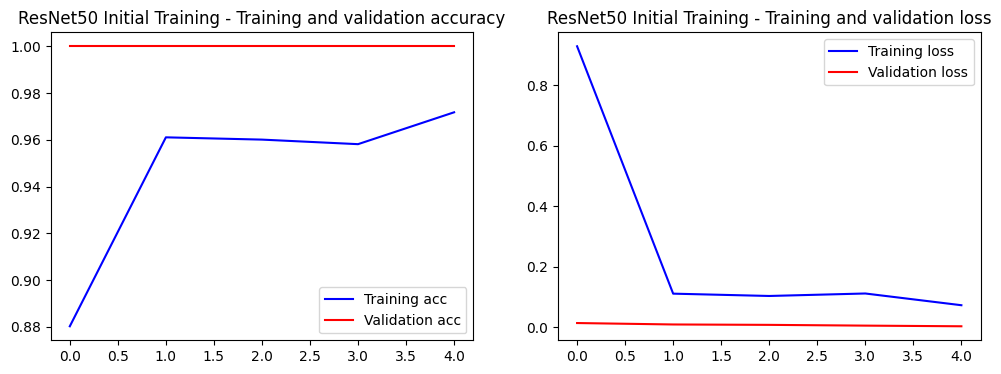

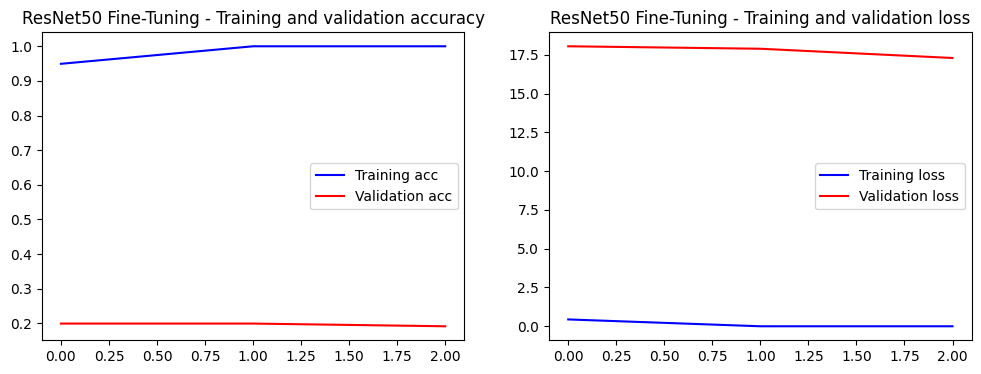

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Define dataset path
dataset_path = r'C:\Users\Dilfina\OneDrive\Desktop\image\sem lab\horse-or-human\horse-or-human'

# Data generators for training and validation sets
data_gen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)
train_data = data_gen.flow_from_directory(
    dataset_path, 
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)
val_data = data_gen.flow_from_directory(
    dataset_path, 
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Function to build the ResNet50 transfer learning model
def build_transfer_model(base_model, learning_rate=0.001):
    base_model.trainable = False
    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

# Initialize the ResNet50 base model and build the complete model
resnet50_base = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
resnet50_model = build_transfer_model(resnet50_base)

# Train the ResNet50 model
print("Training ResNet50 model...")
resnet50_history = resnet50_model.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)

# Fine-tune the model by unfreezing the ResNet50 base
def fine_tune_model(base_model, model, learning_rate=0.0001):
    base_model.trainable = True
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

resnet50_model = fine_tune_model(resnet50_base, resnet50_model)
resnet50_fine_tune_history = resnet50_model.fit(
    train_data,
    validation_data=val_data,
    epochs=3
)

# Load test data and evaluate the model
test_data = data_gen.flow_from_directory(
    dataset_path, 
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Function to evaluate the model and print the confusion matrix and classification report
def evaluate_and_report(model, data, title):
    loss, accuracy = model.evaluate(data)
    print(f'{title} - Test Loss: {loss}, Test Accuracy: {accuracy}')
    
    y_pred = model.predict(data)
    y_pred_classes = (y_pred > 0.5).astype("int32")
    y_true = data.classes

    cm = confusion_matrix(y_true, y_pred_classes)
    print(f"{title} - Confusion Matrix:\n", cm)
    
    print(f"{title} - Classification Report:\n", classification_report(y_true, y_pred_classes))

evaluate_and_report(resnet50_model, test_data, "ResNet50")

# Function to plot training and validation accuracy and loss
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(f'{title} - Training and validation accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'{title} - Training and validation loss')
    plt.legend()
    
    plt.show()

# Plot history for initial training and fine-tuning phases
plot_history(resnet50_history, "ResNet50 Initial Training")
plot_history(resnet50_fine_tune_history, "ResNet50 Fine-Tuning")
